# Laboratorio 4 - Familias de Malware
### Universidad del Valle de Guatemala
### Security Data Science

Andrés de la Roca - 20332

### I. Creacion del dataset / Extraccion de caractersiticas

In [307]:
import pefile
import os
import pandas as pd

#PE Header data
def extract_pe_header_features(file_path):
    pe = pefile.PE(file_path)

    machine_type = pe.FILE_HEADER.Machine
    number_of_sections = pe.FILE_HEADER.NumberOfSections
    time_date_stamp = pe.FILE_HEADER.TimeDateStamp
    characteristics = pe.FILE_HEADER.Characteristics

    return machine_type, number_of_sections, time_date_stamp, characteristics

# Section features
def extract_section_features(file_path):
    pe = pefile.PE(file_path)

    section_features = []
    for section in pe.sections:
        section_name = section.Name.decode('utf-8').rstrip('\x00')
        size_section = section.SizeOfRawData
        characteristics = section.Characteristics

        section_features.append((section_name, size_section, characteristics))

    return section_features

# Imported functions
def extract_imported_functions(file_path):
    pe = pefile.PE(file_path)

    imported_functions = []
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        dll = entry.dll.decode('utf-8')
        for function in entry.imports:
            if function.name is not None:
                imported_functions.append(function.name.decode('utf-8'))

    return imported_functions

# Exported functions
def extract_exported_functions(file_path):
    pe = pefile.PE(file_path)

    exported_functions = []
    if hasattr(pe, 'DIRECTORY_ENTRY_EXPORT'):
        for exp in pe.DIRECTORY_ENTRY_EXPORT.symbols:
            exported_functions.append(exp.name.decode('utf-8'))

    return exported_functions

# Extract strings
def extract_strings(file_path):
    pe = pefile.PE(file_path)
    ascii_strings = []
    unicode_strings = []

    for section in pe.sections:
        ascii_strings.extend(section.get_data().decode('ascii', errors='ignore').split('\x00'))
        unicode_strings.extend(section.get_data().decode('utf-16', errors='ignore').split('\x00'))

    return ascii_strings, unicode_strings


# Dataset creation function
def create_dataset(path):
    dataset = []

    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)

        try:

            if os.path.isfile(file_path):
                pe_header_features = extract_pe_header_features(file_path)
                section_features = extract_section_features(file_path)
                imported_functions = extract_imported_functions(file_path)
                exported_functions = extract_exported_functions(file_path)
                ascii_strings, unicode_strings = extract_strings(file_path)

                entry = {
                    'File_Path': file_path,
                    'PE_Header_Features': pe_header_features,
                    'Section_Features': section_features,
                    'Imported_Functions': imported_functions,
                    'Exported_Functions': exported_functions,
                    # 'ASCII_Strings': ascii_strings,
                    # 'Unicode_Strings': unicode_strings,
                }

                dataset.append(entry)
        except pefile.PEFormatError:
            print('Error reading file: {}'.format(file_path))
            continue

    
    data = pd.DataFrame(dataset)

    return data

In [308]:
path = "./MALWR"

mw_data = create_dataset(path)

print(mw_data)


Error reading file: ./MALWR/.DS_Store
                                           File_Path  \
0      ./MALWR/AAAz2E1B6940985A23E5639450F8391820655   
1       ./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44   
2           ./MALWR/65018CD542145A3792BA09985734C12A   
3           ./MALWR/8442AE37B91F279A9F06DE4C60B286A3   
4      ./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578   
5           ./MALWR/99A39866A657A10949FCB6D634BB30D5   
6        ./MALWR/K99_C3A9A7B026BFE0E55FF219FD6AA7D94   
7       ./MALWR/L11_1415EB8519D13328091CC5C76A624E3D   
8           ./MALWR/F8437E44748D2C3FCF84019766F4E6DC   
9      ./MALWR/POL55_A4F1ECC4D25B33395196B5D51A06790   
10      ./MALWR/DS22_A670D13D4D014169C4080328B8FEB86   
11     ./MALWR/PL98_BD8B082B7711BC980252F988BB0CA936   
12     ./MALWR/KLp90_6D5C8FC4B14559F73B6136D85B94198   
13      ./MALWR/GFT4_7DDD3D72EAD03C7518F5D47650C8572   
14          ./MALWR/1F2EB7B090018D975E6D9B40868C94CA   
15       ./MALWR/RTC_7F85D7F628CE62D1D8F7B39D8940472   
16    ./MA

In [309]:
mw_data.head()

,File_Path,PE_Header_Features,Section_Features,Imported_Functions,Exported_Functions
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"(332, 3, 1319015770, 8462)","[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal..."
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"(332, 3, 1242321160, 271)","[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[]
2,./MALWR/65018CD542145A3792BA09985734C12A,"(332, 3, 1195429813, 271)","[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[]
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"(332, 3, 1263576056, 271)","[(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[]
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"(332, 3, 1319015949, 8462)","[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal..."


In [310]:
print(mw_data['Section_Features'])

0     [(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...
1     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
2     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
3     [(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...
4     [(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...
5     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
6     [(.text, 9728, 1610612768), (.rdata, 3072, 107...
7     [(UPX0, 0, 3758096512), (UPX1, 11776, 37580964...
8     [(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...
9     [(.text, 9728, 1610612768), (.rdata, 3072, 107...
10    [(.text, 9728, 1610612768), (.rdata, 3072, 107...
11    [(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...
12    [(.text, 9728, 1610612768), (.rdata, 3072, 107...
13    [(.text, 9728, 1610612768), (.rdata, 3072, 107...
14    [(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...
15    [(UPX0, 0, 3758096512), (UPX1, 11776, 37580964...
16    [(UPX0, 0, 3758096512), (UPX1, 346112, 3758096...
17    [(UPX0, 0, 3758096512), (UPX1, 4096, 37580

### II. Preprocesamiento de datos

In [311]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

# 1. Normalización para las características numéricas del PE Header
numeric_features = mw_data['PE_Header_Features']
numeric_features = pd.DataFrame(numeric_features.to_list(), columns=['Machine_Type', 'Number_of_Sections', 'TimeDateStamp', 'Characteristics'])
scaler = MinMaxScaler()
mw_data[['Machine_Type', 'Number_of_Sections', 'TimeDateStamp', 'Characteristics']] = scaler.fit_transform(numeric_features)

mw_data.drop(columns=['PE_Header_Features'], inplace=True)

mw_data.head()

,File_Path,Section_Features,Imported_Functions,Exported_Functions,Machine_Type,Number_of_Sections,TimeDateStamp,Characteristics
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...",0.0,0.0,0.999999,1.0
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],0.0,0.0,0.379422,0.0
2,./MALWR/65018CD542145A3792BA09985734C12A,"[(UPX0, 0, 3758096512), (UPX1, 4096, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],0.0,0.0,0.000000,0.0
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"[(UPX0, 0, 3758096512), (UPX1, 3584, 375809644...","[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],0.0,0.0,0.551407,0.0
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"[(UPX0, 0, 3758096512), (UPX1, 342528, 3758096...","[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...",0.0,0.0,1.000000,1.0


In [312]:
# 2. Categorizacion para las características de las secciones
section_features = mw_data['Section_Features']
section_features = section_features.apply(lambda x: [section[0] for section in x])
section_features = section_features.apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer()
section_features = vectorizer.fit_transform(section_features)
section_features = pd.DataFrame(section_features.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, section_features], axis=1)
mw_data.drop(columns=['Section_Features'], inplace=True)

mw_data.head()
# Se enfoco en tomar los nombres de las secciones

,File_Path,Imported_Functions,Exported_Functions,Machine_Type,Number_of_Sections,TimeDateStamp,Characteristics,data,rdata,rsrc,text,upx0,upx1,upx2
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,"[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...",0.0,0.0,0.999999,1.0,0,0,0,0,1,1,1
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,"[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],0.0,0.0,0.379422,0.0,0,0,1,0,1,1,0
2,./MALWR/65018CD542145A3792BA09985734C12A,"[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],0.0,0.0,0.000000,0.0,0,0,1,0,1,1,0
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,"[LoadLibraryA, ExitProcess, GetProcAddress, Vi...",[],0.0,0.0,0.551407,0.0,0,0,1,0,1,1,0
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,"[RegSaveKeyA, BitBlt, LoadLibraryA, GetProcAdd...","[RundllInstall, RundllUninstall, ServiceInstal...",0.0,0.0,1.000000,1.0,0,0,0,0,1,1,1


In [313]:
# 3. Funciones importadas y exportadas
imported_functions = mw_data['Imported_Functions']
imported_functions = imported_functions.apply(lambda x: ' '.join([str(i) for i in x]))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(imported_functions)
imported_functions = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, imported_functions], axis=1)
mw_data.drop(columns=['Imported_Functions'], inplace=True)

exported_functions = mw_data['Exported_Functions']
exported_functions = exported_functions.apply(lambda x: ' '.join([str(i) for i in x]))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(exported_functions)
exported_functions = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
mw_data = pd.concat([mw_data, exported_functions], axis=1)
mw_data.drop(columns=['Exported_Functions'], inplace=True)

mw_data.head()


,File_Path,Machine_Type,Number_of_Sections,TimeDateStamp,Characteristics,data,rdata,rsrc,text,upx0,...,wcsrchr,wcstombs,wsagetlasterror,wsasetlasterror,wsastartup,rundllinstall,rundlluninstall,serviceinstall,servicemain,unserviceinstall
0,./MALWR/AAAz2E1B6940985A23E5639450F8391820655,0.0,0.0,0.999999,1.0,0,0,0,0,1,...,0,0,1,0,0,1,1,1,1,1
1,./MALWR/NBV_8B75BCBFF174C25A0161F30758509A44,0.0,0.0,0.379422,0.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,./MALWR/65018CD542145A3792BA09985734C12A,0.0,0.0,0.000000,0.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,./MALWR/8442AE37B91F279A9F06DE4C60B286A3,0.0,0.0,0.551407,0.0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,./MALWR/AL65_DB05DF0498B59B42A8E493CF3C10C578,0.0,0.0,1.000000,1.0,0,0,0,0,1,...,0,0,1,0,0,1,1,1,1,1


In [314]:
# Deleting redundant columns
mw_data.drop(columns=['File_Path', 'Machine_Type', 'Number_of_Sections'], inplace=True)


In [315]:
mw_data.head()

,TimeDateStamp,Characteristics,data,rdata,rsrc,text,upx0,upx1,upx2,__cxxframehandler,...,wcsrchr,wcstombs,wsagetlasterror,wsasetlasterror,wsastartup,rundllinstall,rundlluninstall,serviceinstall,servicemain,unserviceinstall
0,0.999999,1.0,0,0,0,0,1,1,1,0,...,0,0,1,0,0,1,1,1,1,1
1,0.379422,0.0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.551407,0.0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,1.0,0,0,0,0,1,1,1,0,...,0,0,1,0,0,1,1,1,1,1


### III. Implementacion del modelo

In [316]:
# Guardar el dataset
# mw_data.to_csv('malware_dataset.csv', index=False)

# Cargar el dataset
mw_data = pd.read_csv('malware_dataset.csv')

In [317]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [318]:
X = mw_data.values
print(X)

[[0.99999855 1.         0.         ... 1.         1.         1.        ]
 [0.37942239 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.55140686 0.         0.         ... 0.         0.         0.        ]
 [0.37942239 0.         0.         ... 0.         0.         0.        ]
 [0.56862665 1.         0.         ... 1.         1.         1.        ]]


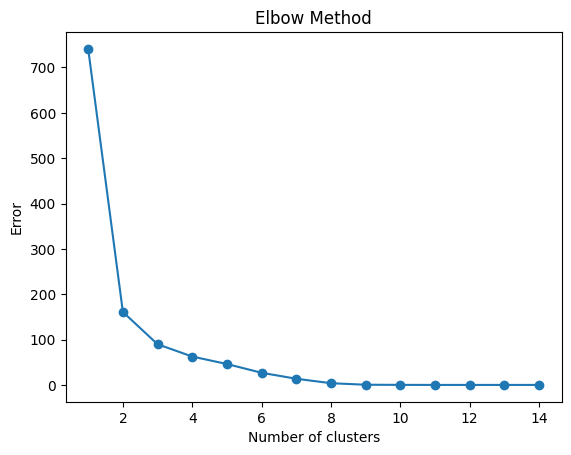

In [319]:
# KMeans - Elbow Method

kmeans_errors = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    kmeans_errors.append(kmeans.inertia_)
plt.plot(range(1, 15), kmeans_errors, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Error')
plt.show()


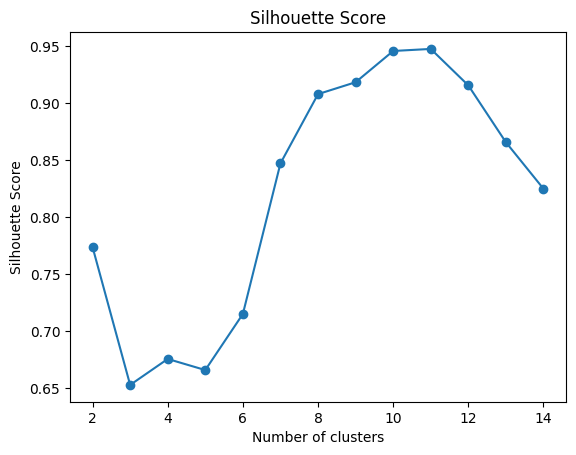

In [320]:
# kmeans - Silhouette score 
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    silhouette_scores.append(silhouette_score(X, labels))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


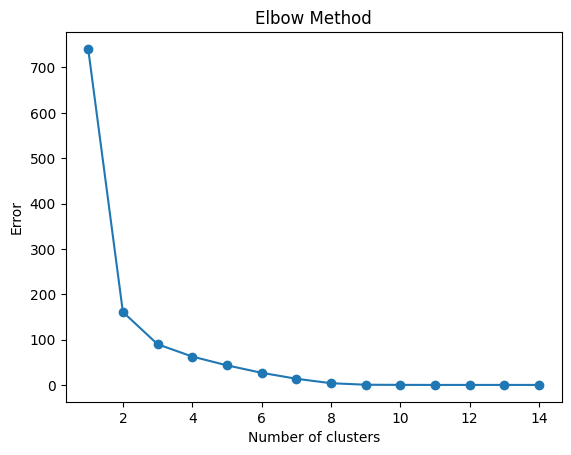

In [321]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min

wcss = []
for i in range(1, 15):
    agg = AgglomerativeClustering(n_clusters=i, linkage='ward')
    agg.fit(X)
    centroids = []
    for cluster in range(i):
        centroids.append(X[agg.labels_ == cluster].mean(axis=0))
    distances = pairwise_distances_argmin_min(X, centroids)[1]
    wcss.append(np.sum(distances ** 2))

plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Error')

plt.show()

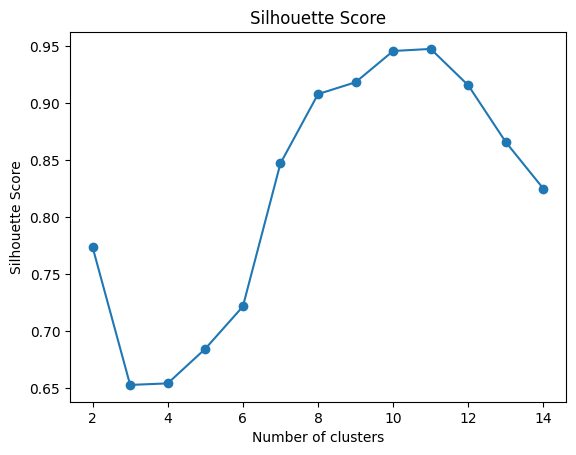

In [322]:
# Agglomerative Clustering - Silhouette score
silhouette_scores = []
for k in range(2, 15):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(X)
    labels = agg.labels_
    silhouette_scores.append(silhouette_score(X, labels))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()
